In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Python"
%ls
import warnings
import pickle
from fastai import *
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from error_metrics_2020_July import *
#from moving_window_tests_mod_dec17 import *
#from utils import *
from darnn_network_modified import *

%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
warnings.filterwarnings(action='ignore')

/content/drive/My Drive/Colab Notebooks/Python
darnn_network_modified.py   moving_window_tests_mod_dec17.py
darnn_network_russia.py     moving_window_tests_mod_dec28.py
error_metrics_2020_July.py  moving_window_tests.py
error_metrics_2020.py       __pycache__/
error_metrics.py            title.jpg
imv_networks.py             utils.py


- data_path = "/content/drive/My Drive/Colab Notebooks/Data"
- py_path = "/content/drive/My Drive/Colab Notebooks/Python"

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Data"
# Dataset is now stored in a Pandas Dataframe.
data = pd.read_csv("nasdaq100_padding.csv")
data.shape

/content/drive/My Drive/Colab Notebooks/Data


(40560, 82)

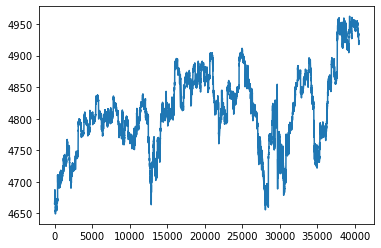

In [ ]:
data['NDX'].plot()

In [ ]:
batch_size = 128
timesteps = 50 # lookback
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"
prediction_horizon = 1

X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))
#---
for i, name in enumerate(list(data.columns[:-1])):
  for j in range(timesteps):
    X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

for j in range(timesteps):
  y[:,j,0] = data[target].shift(timesteps - j - 1).fillna(method='bfill')
#---
# make lag variable
prediction_horizon=1
target = data['NDX'].shift(-prediction_horizon).fillna(method='ffill').values

# start from timstep because we bfilled
X=X[timesteps:]
y=y[timesteps:]
target=target[timesteps:]

X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

# Normalize based on training data
# Use it to recover back to original series

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [ ]:
import torch
from torch import nn
from torch import tensor, Tensor
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import pickle

In [ ]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)
target_test_t.dtype, target_val_t.dtype, target_test_t.dtype

(torch.float32, torch.float32, torch.float32)

In [ ]:
train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

In [ ]:
model = DARNN(X_train.shape[2], 128, 128, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
Iter:  0 train:  0.1558447524248179 val:  0.2972334715269623
Iter time:  72.19940443799987
rmse:  77.97831 mae:  65.68989
lr:  0.001


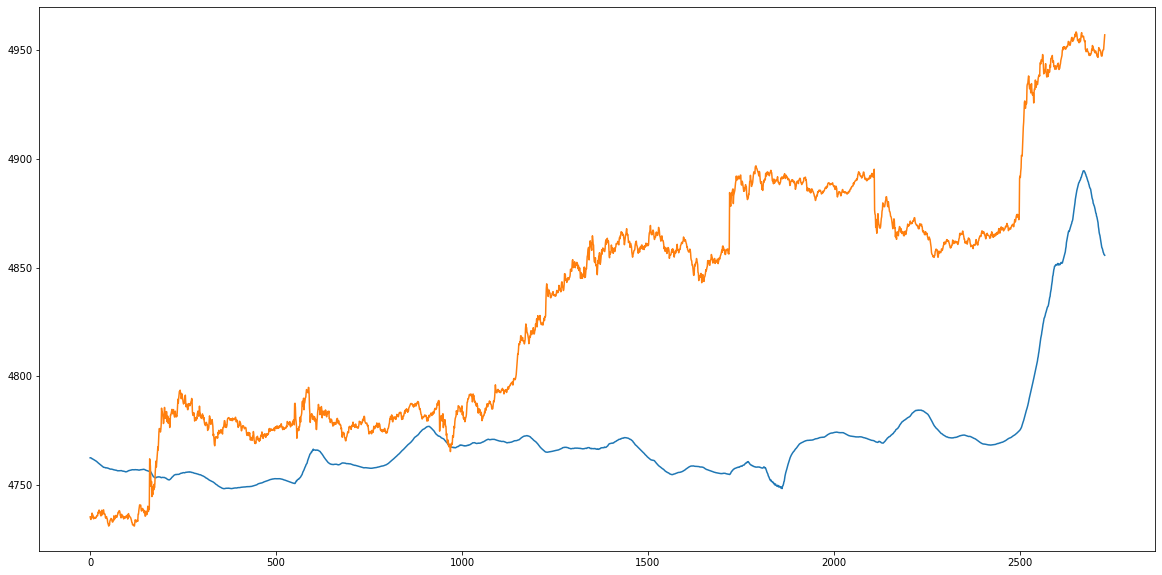

Saving...
Iter:  1 train:  0.041718243119363715 val:  0.10580829259691518
Iter time:  71.06878897799993
Saving...
Iter:  2 train:  0.03215921450359945 val:  0.0483388237749071
Iter time:  71.10611754699994
Saving...
Iter:  3 train:  0.020348607481988766 val:  0.028761360405905663
Iter time:  70.17419348299995
Saving...
Iter:  4 train:  0.014512413546845734 val:  0.01833899514334526
Iter time:  70.52069323400019
Saving...
Iter:  5 train:  0.012396520984665276 val:  0.015285380708107702
Iter time:  71.40831402799995
Iter:  6 train:  0.011883024288074504 val:  0.01635955514616418
Iter time:  70.62883354699989
Saving...
Iter:  7 train:  0.010944400146236264 val:  0.01354747939660322
Iter time:  70.4034662590002
Saving...
Iter:  8 train:  0.011091259539131718 val:  0.010760555311090748
Iter time:  71.59192851200032
Iter:  9 train:  0.010114997235326535 val:  0.011160848764097182
Iter time:  72.23264565
Iter:  10 train:  0.009744632246537183 val:  0.012156267729487077
Iter time:  70.22603488

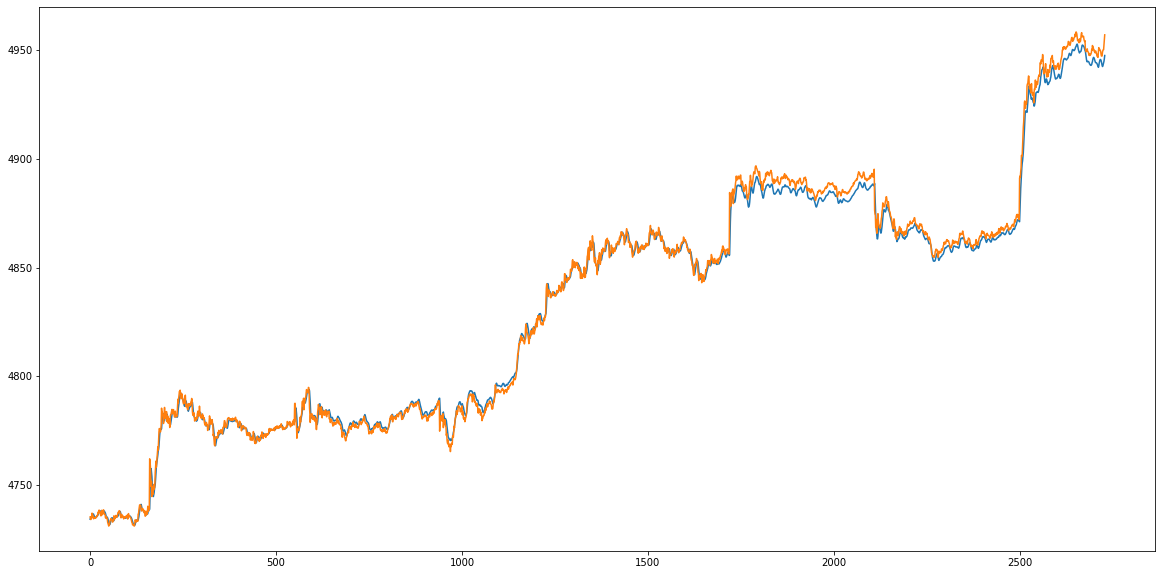

Iter:  11 train:  0.010125035976247133 val:  0.011287329822746854
Iter time:  71.01082940200013
Saving...
Iter:  12 train:  0.009355671790929268 val:  0.008345645387282552
Iter time:  71.12437293700032
Iter:  13 train:  0.009024735088373816 val:  0.009105976003840024
Iter time:  70.29632473699985
Iter:  14 train:  0.009217751237352101 val:  0.00992264205193669
Iter time:  71.59084857399966
Iter:  15 train:  0.00856022395750075 val:  0.00944013402277198
Iter time:  70.13724662599998
Iter:  16 train:  0.008647091697442892 val:  0.0137044743346599
Iter time:  70.31738909100022
Saving...
Iter:  17 train:  0.008172654433860404 val:  0.007338665567795593
Iter time:  72.15928569700009
Saving...
Iter:  18 train:  0.008338343687859085 val:  0.007102477983751898
Iter time:  72.02922894899984
Iter:  19 train:  0.007895052899860002 val:  0.00742898572182773
Iter time:  71.68343441600018
Iter:  20 train:  0.007538777585377709 val:  0.015603373319618993
Iter time:  72.20210831900022
rmse:  4.0934954

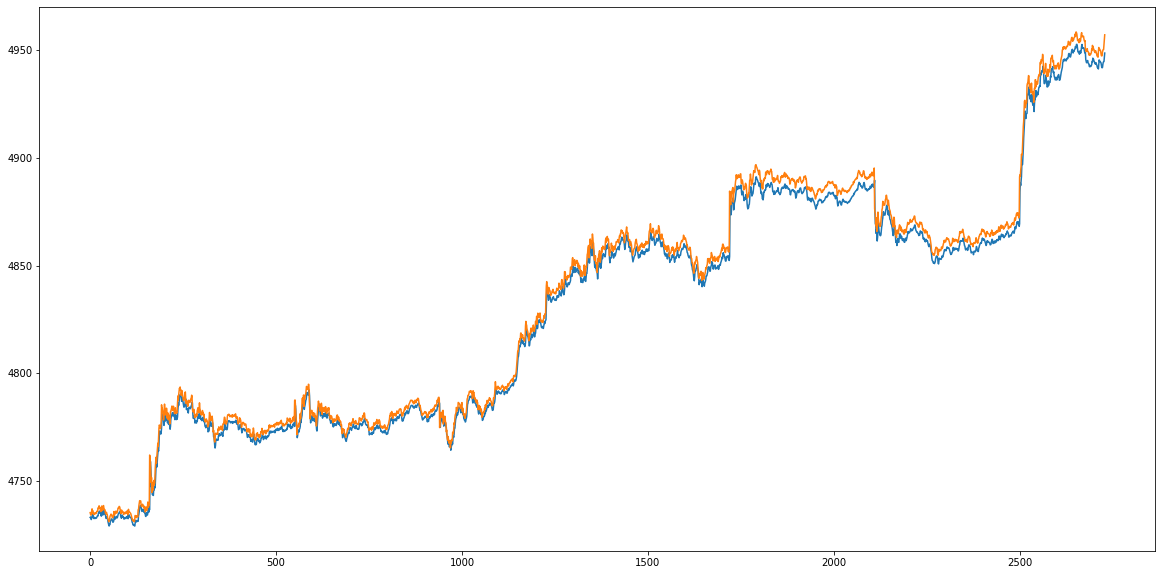

Saving...
Iter:  21 train:  0.007898492315654452 val:  0.006470126242160843
Iter time:  73.394933993
Iter:  22 train:  0.007482135955267549 val:  0.00658278888129861
Iter time:  71.74565141199992
Saving...
Iter:  23 train:  0.0077361742484901574 val:  0.006345405747686152
Iter time:  71.46942980799986


In [ ]:
epochs = 150
loss = nn.MSELoss()
patience = 20
min_val_loss = 9999
counter = 0
train_loss=[]
valid_loss=[]

for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y_h, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred,attention,temporal = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    train_loss.append(mse_train)
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output, _,_ = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    valid_loss.append(mse_val)
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        fname = 'darnn_colab_ndx' + '_' + str(timesteps) + '.pt'
        torch.save(model.state_dict(), fname)
        with open("attention.txt","wb") as fp:
          pickle.dump(attention.detach().cpu().numpy(),fp)
        with open("temporal.txt","wb") as fp:
          pickle.dump(temporal.detach().cpu().numpy(),fp)
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:

        torch.save(model.state_dict(), "darnn_colab_ndx_last.pt")
        print('reached patience')
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        rmse = np.sqrt(mean_squared_error(true, preds))
        mae = mean_absolute_error(true, preds)
        print("rmse: ", rmse, "mae: ", mae)
        print("lr: ", opt.param_groups[0]["lr"])
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()


In [ ]:
%ls

attention.txt            darnn_colab_ndx.pt     temporal.txt
darnn_colab_ndx_last.pt  nasdaq100_padding.csv


In [ ]:
model.load_state_dict(torch.load("darnn_colab_ndx.pt"))
with open("attention.txt","rb") as fp:
  attention = pickle.load(fp)
with open("temporal.txt","rb") as fp:
  temporal = pickle.load(fp)

In [ ]:
type(attention), attention.shape, type(temporal), temporal.shape
#temporal=temporal.reshape(attention.shape[0],timesteps)

(numpy.ndarray, (28, 81), numpy.ndarray, (28, 20, 1))

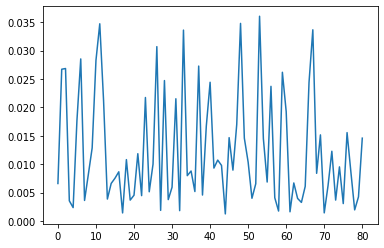

In [ ]:
plt.plot(attention[-1,:])

In [ ]:
attention[-1,:]

array([0.00661032, 0.02672425, 0.02684884, 0.00356362, 0.00236943,
       0.01770458, 0.02853645, 0.0036289 , 0.00822568, 0.01287101,
       0.02828699, 0.03472185, 0.02119623, 0.00387481, 0.00661971,
       0.00754363, 0.0086712 , 0.00143178, 0.01081721, 0.00369137,
       0.00455001, 0.01185576, 0.00447627, 0.02174731, 0.00515631,
       0.01001984, 0.03069942, 0.00188196, 0.02473013, 0.00377785,
       0.00595943, 0.02152496, 0.00183141, 0.03361149, 0.00799265,
       0.00880874, 0.00519631, 0.0272801 , 0.00458107, 0.01668696,
       0.0244296 , 0.0093267 , 0.01073302, 0.00979369, 0.00125801,
       0.0146803 , 0.00896705, 0.01699356, 0.03478855, 0.01459296,
       0.01036587, 0.00401222, 0.00656751, 0.03604961, 0.01452936,
       0.0068699 , 0.02371204, 0.00410571, 0.00176516, 0.02618853,
       0.01927615, 0.00163114, 0.0067061 , 0.00398408, 0.00328287,
       0.00611183, 0.02440059, 0.03366475, 0.00840235, 0.01516854,
       0.00143985, 0.00623564, 0.01228627, 0.00369335, 0.00953

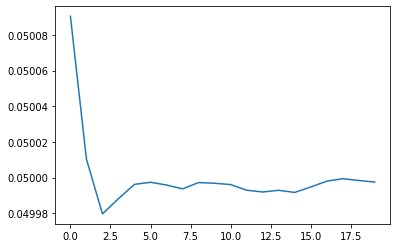

In [ ]:
plt.plot(temporal[-1])

In [ ]:
loss = nn.MSELoss()

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output, _,_ = model(batch_x, batch_y_h)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [ ]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
evaluate(preds, true)

{'mape': 0.02307184477103874,
 'mda': 0.712348845731037,
 'mdd': -0.07860064506530762,
 'mds': 0.35742885300247346,
 'mnda': 0.9152298850574713,
 'mnp': 0.6563626996393611,
 'mpda': 0.5011219147344802,
 'mpp': 0.850253807106599,
 'pct_r': 43.00735463977476,
 'rmse': 1.5809438,
 'sr': 7.8246201209989}

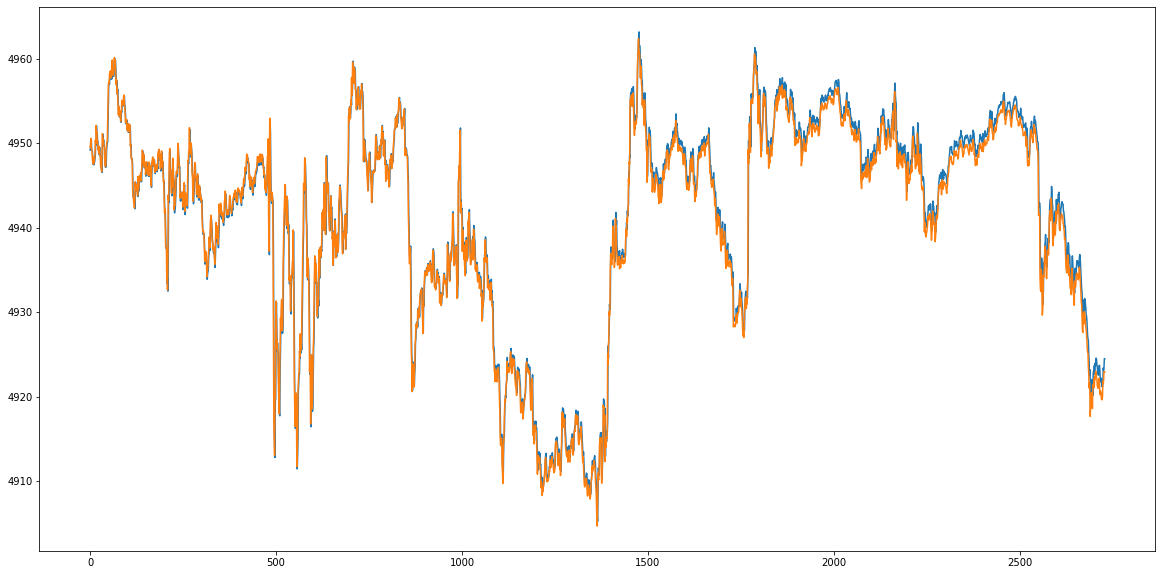

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [ ]:
plt.plot(valid_loss[1:])

NameError: ignored

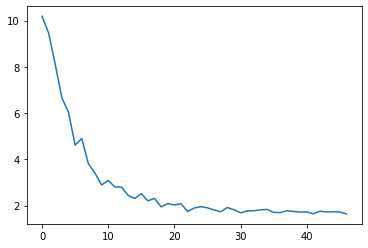

In [ ]:
plt.plot(train_loss[1:])

In [ ]:
model.load_state_dict(torch.load("darnn_colab_ndx_last.pt"))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output, _,_ = model(batch_x, batch_y_h)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)
evaluate(preds, true)

{'mape': 0.02307184477103874,
 'mda': 0.712348845731037,
 'mdd': -0.07860064506530762,
 'mds': 0.35742885300247346,
 'mnda': 0.9152298850574713,
 'mnp': 0.6563626996393611,
 'mpda': 0.5011219147344802,
 'mpp': 0.850253807106599,
 'pct_r': 43.00735463977476,
 'rmse': 1.5809438,
 'sr': 7.8246201209989}

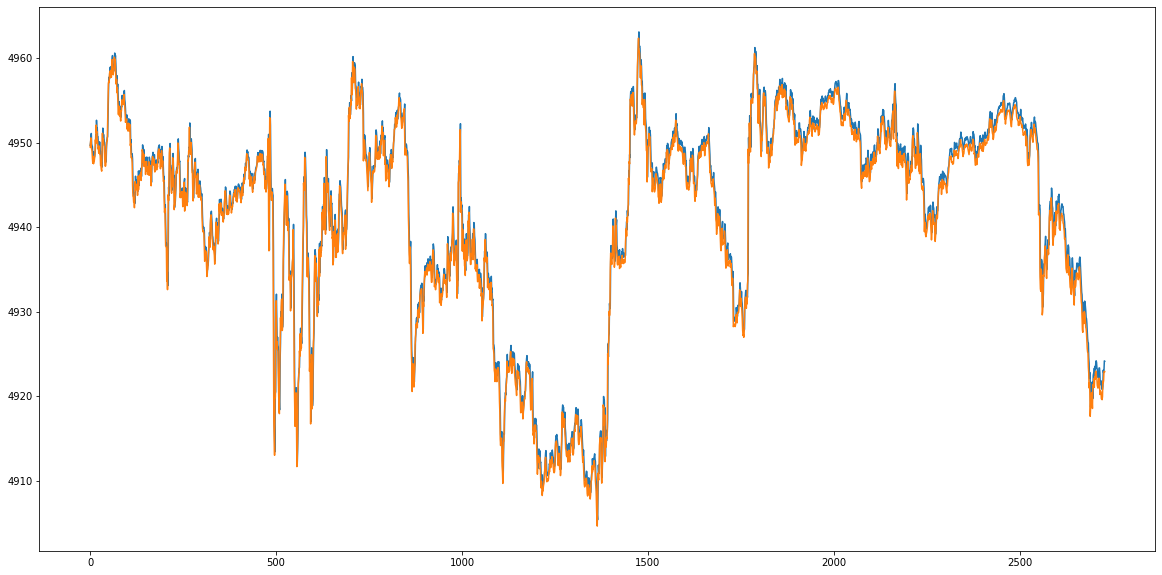

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()